In [7]:
%load_ext autoreload
%autoreload 2
import sys
import os
notebook_dir = os.path.dirname(os.path.abspath(''))
if notebook_dir not in sys.path:
    sys.path.append(os.path.dirname(notebook_dir))
from notebooks.config import *

import anndata
import numpy as np
import scanpy as sc
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
print("Loading snRNA-seq data...")
myfilename = os.path.join(SNRNA_DATA_DIR, "snRNAseq_LCNE_BN_d4_1-5k.h5ad")
adata_foo = sc.read_h5ad(myfilename)
adata_BN = anndata.AnnData(adata_foo.layers['BN'])
adata_BN.obs = adata_foo.obs.copy()
adata_BN.obsm = adata_foo.obsm.copy()
adata_BN.var = adata_foo.var.copy()

print(f"Data shape: {adata_BN.shape}")

# Prepare data for analysis
print("Preparing data for analysis...")
adata_sc = adata_BN.copy()
adata_sc.raw=adata_sc.copy()

Loading snRNA-seq data...
Data shape: (4895, 1500)
Preparing data for analysis...


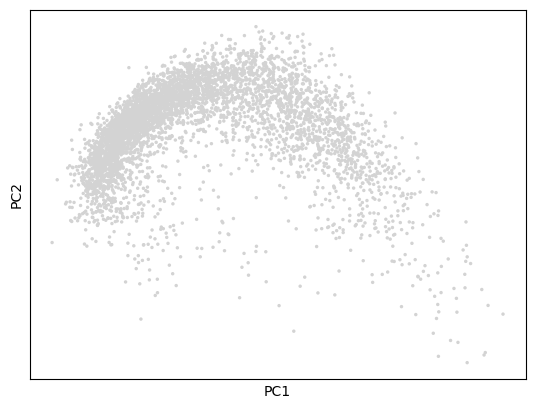

In [15]:
sc.pl.pca(adata_sc)


# -----------------------
# 1. GMM + AIC/BIC
# -----------------------

In [10]:

# Reduce to PCA space (use enough PCs to capture variation, e.g., 50)
sc.tl.pca(adata_sc, n_comps=50, svd_solver='arpack')
X_pca = adata_sc.obsm['X_pca']

aic_scores = []
bic_scores = []
ks = range(1, 6)

for k in ks:
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(X_pca)
    aic_scores.append(gmm.aic(X_pca))
    bic_scores.append(gmm.bic(X_pca))

print("AIC:", dict(zip(ks, aic_scores)))
print("BIC:", dict(zip(ks, bic_scores)))


AIC: {1: -2487804.043273926, 2: -2542426.590698242, 3: -2566753.8564453125, 4: -2579586.3571777344, 5: -2583033.3885498047}
BIC: {1: -2479196.8836135976, 2: -2525205.775408031, 3: -2540919.385525218, 4: -2545138.230627757, 5: -2539971.6063699443}


AIC: {1: -2487804.043273926, 2: -2542426.590698242, 3: -2566753.8564453125, 4: -2579586.3571777344, 5: -2583033.6873168945}
BIC: {1: -2479196.8836135976, 2: -2525205.775408031, 3: -2540919.385525218, 4: -2545138.230627757, 5: -2539971.905137034}


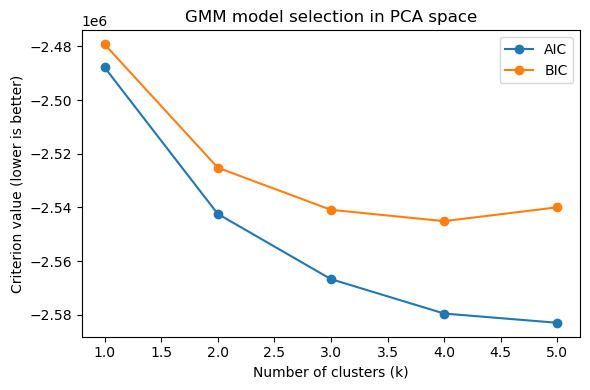

In [12]:
sc.tl.pca(adata_sc, n_comps=50, svd_solver='arpack')
X = adata_sc.obsm['X_pca']  # shape ~ (N, 50)

ks = range(1, 6)
aic_scores, bic_scores = [], []

for k in ks:
    gmm = GaussianMixture(
        n_components=k,
        covariance_type='full',
        random_state=0
    ).fit(X)
    aic_scores.append(gmm.aic(X))
    bic_scores.append(gmm.bic(X))

print("AIC:", dict(zip(ks, aic_scores)))
print("BIC:", dict(zip(ks, bic_scores)))

# Plot AIC/BIC
plt.figure(figsize=(6,4))
plt.plot(list(ks), aic_scores, marker='o', label='AIC')
plt.plot(list(ks), bic_scores, marker='o', label='BIC')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Criterion value (lower is better)")
plt.title("GMM model selection in PCA space")
plt.legend()
plt.tight_layout()
plt.show()



# -----------------------
# 2. Bootstrap Jaccard Stability (KMeans example)
# -----------------------

In [11]:

def bootstrap_jaccard(X, n_clusters, n_boot=20, subsample=0.8, random_state=0):
    np.random.seed(random_state)
    n = X.shape[0]
    labels_list = []
    for _ in range(n_boot):
        idx = np.random.choice(n, int(subsample * n), replace=False)
        km = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X[idx])
        labels_full = -np.ones(n, dtype=int)
        labels_full[idx] = km.labels_
        labels_list.append(labels_full)

    # Compute mean pairwise Jaccard index for points that are clustered in both runs
    jaccards = []
    for i in range(n_boot):
        for j in range(i + 1, n_boot):
            mask = (labels_list[i] != -1) & (labels_list[j] != -1)
            if mask.sum() > 0:
                jaccards.append(jaccard_score(
                    labels_list[i][mask],
                    labels_list[j][mask],
                    average='macro'
                ))
    return np.mean(jaccards)

stability_scores = {k: bootstrap_jaccard(X_pca, n_clusters=k) for k in ks}
print("Bootstrap Jaccard stability:", stability_scores)


Bootstrap Jaccard stability: {1: 1.0, 2: 0.5165046092005466, 3: 0.3264574511970893, 4: 0.20778260900426773, 5: 0.16213535533184512}


Bootstrap ARI stability: {1: 1.0, 2: 0.9165432827794443, 3: 0.8508289053652092, 4: 0.8023194346045117, 5: 0.6734817916584822}


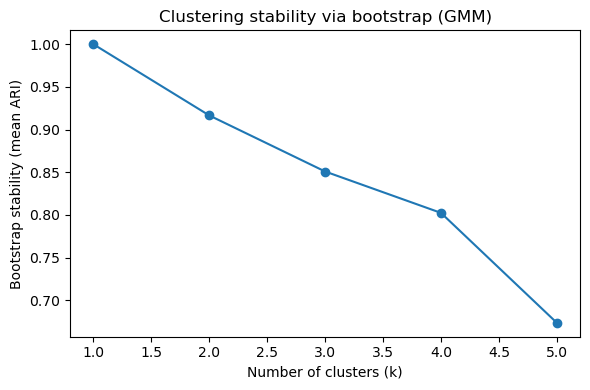

In [14]:
from sklearn.metrics import adjusted_rand_score

# =======================================
# 2) Stability via bootstrap ARI (GMM)
# =======================================
def bootstrap_ari_gmm(X, n_clusters, n_boot=20, subsample=0.8, random_state=0):
    """
    For each bootstrap:
      - draw a subset of cells
      - fit a GMM(k)
      - store (indices, labels)
    Then compute ARI between all pairs of runs on the overlap.
    Return mean ARI.
    """
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    runs = []

    for b in range(n_boot):
        idx = rng.choice(n, int(subsample * n), replace=False)
        gmm = GaussianMixture(
            n_components=n_clusters,
            covariance_type='full',
            random_state=42 + b  # vary seed across boots a bit
        ).fit(X[idx])
        labels = gmm.predict(X[idx])
        runs.append((idx, labels))

    # pairwise ARI over overlaps
    aris = []
    for i in range(len(runs)):
        idx_i, lab_i = runs[i]
        for j in range(i+1, len(runs)):
            idx_j, lab_j = runs[j]
            # overlap
            common = np.intersect1d(idx_i, idx_j, assume_unique=False)
            if common.size == 0:
                continue
            # map to local positions
            pos_i = np.searchsorted(np.sort(idx_i), common)
            pos_j = np.searchsorted(np.sort(idx_j), common)
            # need labels aligned to sorted indices
            order_i = np.argsort(idx_i)
            order_j = np.argsort(idx_j)
            lab_i_sorted = lab_i[order_i]
            lab_j_sorted = lab_j[order_j]
            aris.append(adjusted_rand_score(lab_i_sorted[pos_i], lab_j_sorted[pos_j]))

    return float(np.mean(aris)) if len(aris) else np.nan

stability_scores = {k: bootstrap_ari_gmm(X, n_clusters=k, n_boot=20, subsample=0.8, random_state=0)
                    for k in ks}
print("Bootstrap ARI stability:", stability_scores)

# Plot stability
plt.figure(figsize=(6,4))
plt.plot(list(stability_scores.keys()),
         list(stability_scores.values()),
         marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Bootstrap stability (mean ARI)")
plt.title("Clustering stability via bootstrap (GMM)")
plt.tight_layout()
plt.show()

In [ ]:

# ===== PCA space =====
sc.tl.pca(adata_sc, n_comps=50, svd_solver='arpack')
X_real = adata_sc.obsm['X_pca']

ks = range(1, 6)

# ===== Bootstrap stability function =====
def bootstrap_ari_gmm(X, n_clusters, n_boot=20, subsample=0.8, random_state=0):
    rng = np.random.default_rng(random_state)
    n = X.shape[0]
    runs = []
    for b in range(n_boot):
        idx = rng.choice(n, int(subsample * n), replace=False)
        gmm = GaussianMixture(
            n_components=n_clusters,
            covariance_type='full',
            random_state=42 + b
        ).fit(X[idx])
        labels = gmm.predict(X[idx])
        runs.append((idx, labels))

    # pairwise ARI on overlaps
    aris = []
    for i in range(len(runs)):
        idx_i, lab_i = runs[i]
        for j in range(i+1, len(runs)):
            idx_j, lab_j = runs[j]
            common = np.intersect1d(idx_i, idx_j)
            if common.size == 0:
                continue
            pos_i = np.searchsorted(np.sort(idx_i), common)
            pos_j = np.searchsorted(np.sort(idx_j), common)
            order_i = np.argsort(idx_i)
            order_j = np.argsort(idx_j)
            lab_i_sorted = lab_i[order_i]
            lab_j_sorted = lab_j[order_j]
            aris.append(adjusted_rand_score(lab_i_sorted[pos_i], lab_j_sorted[pos_j]))

    return float(np.mean(aris)) if len(aris) else np.nan

# ===== 1) Observed stability =====
obs_stability = {k: bootstrap_ari_gmm(X_real, n_clusters=k) for k in ks}

# ===== 2) Null stability via permutation =====
X_null = X_real.copy()
rng = np.random.default_rng(0)
for pc in range(X_null.shape[1]):
    rng.shuffle(X_null[:, pc])  # permute within each PC

null_stability = {k: bootstrap_ari_gmm(X_null, n_clusters=k) for k in ks}

# ===== Print results =====
print("Observed stability:", obs_stability)
print("Null stability (permuted PCs):", null_stability)

# ===== Plot comparison =====
plt.figure(figsize=(6,4))
plt.plot(list(obs_stability.keys()), list(obs_stability.values()),
         marker='o', label='Observed data')
plt.plot(list(null_stability.keys()), list(null_stability.values()),
         marker='o', label='Permuted (null)')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Bootstrap stability (mean ARI)")
plt.title("Observed vs Null clustering stability")
plt.legend()
plt.tight_layout()
plt.show()